In [50]:
%matplotlib inline

In [51]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [52]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import d2l

torch.set_default_tensor_type(torch.FloatTensor)

In [53]:
train_data = pd.read_csv("./dataset/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("./dataset/house-prices-advanced-regression-techniques/test.csv")

In [54]:
test_data.shape

(1459, 80)

In [55]:
train_data.shape

(1460, 81)

In [56]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [57]:
all_features.shape

(2919, 79)

In [58]:
train_data.iloc[0,-1]

208500

### #对数值特征进行标准化standardization

every_numeric_feature_value: $v$

mean of column: $\mu$

variance of column: $\sigma$

$$
standardization \rightarrow \frac{v-\mu}{\sigma}
$$

In [59]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index#筛选出值为数字的列

In [60]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [61]:
all_features[numeric_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,6,2006
1455,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,286.0,0,24,0,0,0,0,0,4,2006
1456,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,576.0,474,0,0,0,0,0,0,9,2006
1457,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [62]:
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean())/(x.std())
)
#进行标准化后，每列数值特征的均值变为0，对于缺失值，可以使用0来代替

all_features[numeric_features] = all_features[numeric_features].fillna(0)


In [63]:
all_features[numeric_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,-2.195385,-0.740634,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.078492,-1.363335
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,-0.867591,-0.740634,-0.347564,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.815205,-1.363335
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0.478774,3.005615,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,-1.363335
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,-2.195385,-0.108355,-0.229178,-0.359539,-0.103313,-0.285886,-0.063139,1.144116,0.289865,-1.363335


#### 对于离散特征，进行拆分表示

In [64]:
all_features=pd.get_dummies(all_features,dummy_na=True)#以nan为缺失值

In [65]:
all_features.shape

(2919, 331)

In [66]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [67]:
n_train = train_data.shape[0]
n_train

1460

In [68]:
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

In [69]:
loss = torch.nn.MSELoss()

In [70]:
def define_net(nums_of_features):
    net=torch.nn.Linear(nums_of_features,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

#### 对数均方根误差

给定预测标签$\hat{y}_1,\cdots,\hat{y}_n$和对应的真实标签$y_1,\cdots,y_n$：

$$LOG\_RMSE =  \sqrt{\frac{1}{n} \sum\limits_{i=1}^n((\log(y_i)-log(\hat{y}_i))^2} $$

In [71]:
def log_rmse(net,features,labels):
    #这里我们只是来求rmse，因此不能开自动求导
    with torch.no_grad():
        clipped_data = torch.max(net(features),torch.tensor(1.0))#将小于1的值设为1，使得取对数时值更稳定
        rmse = torch.sqrt(loss(clipped_data.log(),labels.log()))
    return rmse.item()

In [72]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_loss , test_loss = [],[]
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    #小批量优化
    optimizer = torch.optim.Adam(params=net.parameters(),lr = learning_rate, weight_decay=weight_decay)
    net=net.float()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            loss__ = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            loss__.backward()
            optimizer.step()
        train_loss.append(log_rmse(net,train_features,train_labels))#在整个训练集上去看均方误差
        if test_labels is not None:
            test_loss.append(log_rmse(net,test_features,test_labels))#在整个测试集上去看均方误差
    return train_loss,test_loss

#### K折交叉验证

In [73]:
def get_k_fold_data(k,i,X,y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train , y_train=None,None
    
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part, y_part = X[idx,:],y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part #验证集
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat((X_train,X_part),dim=0)
            y_train=torch.cat((y_train,y_part),dim=0)
    
    return X_train,y_train,X_valid,y_valid

In [74]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_loss_sum, valid_loss_sum = 0.0,0.0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = define_net(X_train.shape[1])
        train_loss,valid_loss = train(net,data[0],data[1],data[2],data[3],num_epochs,learning_rate,weight_decay,batch_size)
        train_loss_sum+=train_loss[-1]
        valid_loss_sum+=valid_loss[-1]#num_epochs过后的loss
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_loss,
                         ['train', 'valid'])
        print('fold: %d, train_rmse: %f, valid_rmse: %f' %(i,train_loss[-1],valid_loss[-1]))
    
    return train_loss_sum/k, valid_loss_sum/k#平均每折loss



fold: 0, train_rmse: 0.170466, valid_rmse: 0.156875
fold: 1, train_rmse: 0.162496, valid_rmse: 0.189338
fold: 2, train_rmse: 0.164034, valid_rmse: 0.168219
fold: 3, train_rmse: 0.168341, valid_rmse: 0.154885
fold: 4, train_rmse: 0.163266, valid_rmse: 0.183156


(0.1657204270362854, 0.17049438059329985)

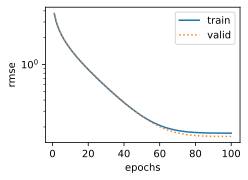

In [75]:
k_fold(5,train_features,train_labels,100,5,0,64)#学习率怎么选择的这么大

#### 小结
后面的提交kaggle预测结果，暂时就不做了。
体会：
1. 真实数据要经过预处理
2. 可以使用K折交叉验证来选择模型并调节参数